In [136]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import pcmdpy as ppy
from astropy.io import fits
import os, time
import seaborn.apionly as sns
from scipy.stats import norm, gaussian_kde, ks_2samp
%matplotlib inline

In [3]:
from test_simulate import *

In [4]:
ppy.gpu_utils.initialize_gpu(n=0)

using given n: 0
Starting SourceModule Code
Getting function
Past the SourceModule code
CUDAC Available


In [6]:
psf = fits.open('psf.fits')[0].data.astype(float)
d_CenA = 3.8 #mpc, https://doi.org/10.1071/AS09063

In [7]:
filters = []
filters.append(make_filter('sbf_im/f814w_1.fits', d_CenA, psf, 'F814W', 'ACS_WFC_F814W'))
filters.append(make_filter('sbf_im/f822n.fits', d_CenA, psf, 'F8230', 'ACS_RAMP_8230'))
filters.append(make_filter('sbf_im/f835n.fits', d_CenA, psf, 'F8365', 'ACS_RAMP_8365'))
filters.append(make_filter('sbf_im/f855n.fits', d_CenA, psf, 'F8560', 'ACS_RAMP_8560'))
filters.append(make_filter('sbf_im/f878n.fits', d_CenA, psf, 'F8800', 'ACS_RAMP_8800'))

#Initialize the isochrone Models using Aaron's custom MIST bolometric corrections
iso_model = ppy.isochrones.Isochrone_Model(filters, MIST_path='HST_ACS_RAMP/', append='.iso.HST_ACS_RAMP')
driv = ppy.driver.Driver(iso_model, gpu=True)

/n/home01/bcook/.conda/envs/my_home/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [14]:
hdu1 = fits.open('sbf_im/f814w_1.fits')[0]

In [19]:
data = hdu1.data
data = data[data > 0.].flatten()
data

array([ 0.98965609,  1.02705121,  0.96527237, ...,  0.99534339,
        1.08559942,  1.07624698], dtype=float32)

In [20]:
f0 = filters[0]

In [66]:
mags0 = f0.counts_to_mag(data * f0._exposure)
mean0, std0 = np.mean(mags0), np.std(mags0)
kde0 = gaussian_kde(mags0)

In [153]:
logNpix = np.arange(3,4.1, .1).astype(float)
age = np.arange(9.0, 10.1, .1)
Nim = 256
results = {}
sbf = {}
ints = np.zeros((len(logNpix), len(age)))
pvals = np.zeros((len(logNpix), len(age)))
for i,N in enumerate(logNpix):
    print(i)
    for j,a in enumerate(age):
        params = np.array([0., -2., N, a])
        gal = ppy.galaxy.Galaxy_SSP(params)
        mags, im = driv.simulate(gal, Nim, fixed_seed=True)
        ints[i,j] = kde0.integrate_gaussian(np.mean(mags[0]), np.std(mags[0]))
        pvals[i,j],_ = ks_2samp(mags0, mags[0])
#         pvals[i,j] = np.log10(p)
        results[i,j] = mags[0]
        sbf[i,j] = im[0].flatten() / np.mean(im[0])

0
1
2
3
4
5
6
7
8
9
10


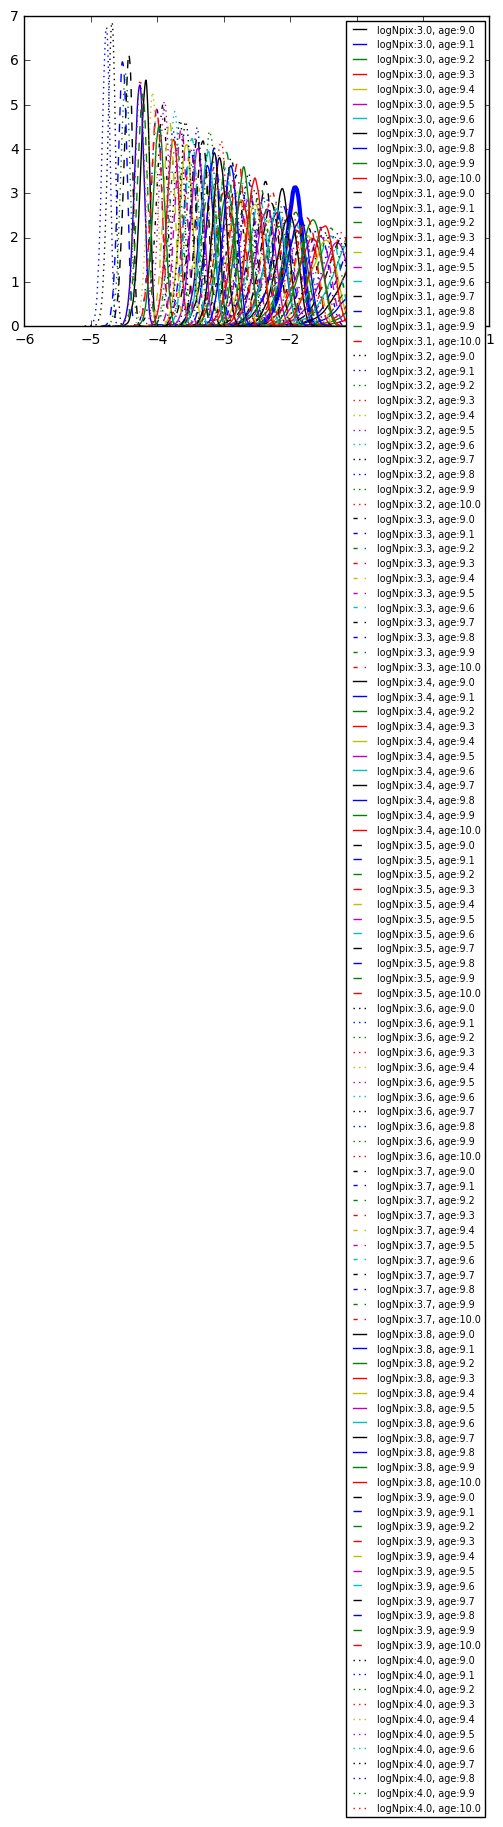

In [149]:
sns.kdeplot(mags0, lw=3)
ls = ['-', '--', ':', '-.','-','--',':','-.','-','--',':','-.']
color = ['k','b','g','r','y','m','c', 'k','b','g','r']
for i,N in enumerate(logNpix):
    for j,a in enumerate(age):
        N = logNpix[i]
        a = age[j]
        sns.kdeplot(results[i,j], label='logNpix:{:.1f}, age:{:.1f}'.format(N,a), ls=ls[i], c=color[j])
plt.legend(fontsize='x-small')
# plt.xlim([-3, -1])

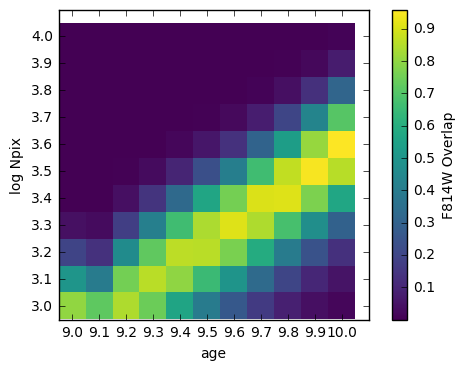

In [150]:
plt.imshow(ints, cmap='viridis', interpolation='None', extent=(0,1,0,1), origin='lower')
plt.xlabel('age'), plt.ylabel('log Npix')
x = np.linspace(0,1,len(age)+1)
x += 0.5*x[1]
y = np.linspace(0,1,len(logNpix)+1)
y += 0.5*y[1]
plt.xticks(x, age)
plt.yticks(y, logNpix)
plt.colorbar(label='F814W Overlap')

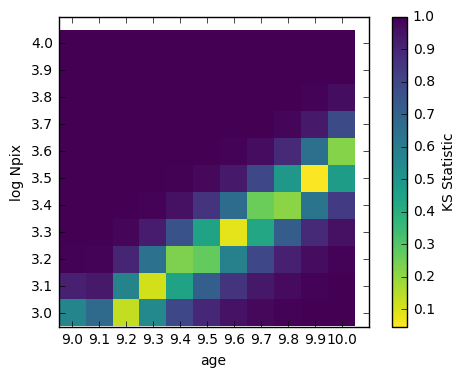

In [156]:
plt.imshow(pvals, cmap='viridis_r', interpolation='None', extent=(0,1,0,1), origin='lower')
plt.xlabel('age'), plt.ylabel('log Npix')
x = np.linspace(0,1,len(age)+1)
x += 0.5*x[1]
y = np.linspace(0,1,len(logNpix)+1)
y += 0.5*y[1]
plt.xticks(x, age)
plt.yticks(y, logNpix)
plt.colorbar(label='KS Statistic')

In [155]:
pvals

array([[ 0.5615192 ,  0.67528692,  0.12966755,  0.55187002,  0.79793694,
         0.8987278 ,  0.95414506,  0.97850514,  0.99233411,  0.99743573,
         0.99904619],
       [ 0.9135739 ,  0.93655906,  0.57243521,  0.11032195,  0.44184087,
         0.71657345,  0.85548059,  0.93732042,  0.97359261,  0.99220003,
         0.99789474],
       [ 0.98997143,  0.99253172,  0.90188298,  0.64628928,  0.23184929,
         0.27302426,  0.57967946,  0.79812876,  0.91607783,  0.96673113,
         0.98926115],
       [ 0.99892525,  0.99923615,  0.98755019,  0.92854607,  0.7605241 ,
         0.44378188,  0.08451384,  0.4277167 ,  0.71985445,  0.88536831,
         0.95810262],
       [ 0.99986684,  0.99989299,  0.99862869,  0.99177714,  0.95904723,
         0.85661442,  0.66286233,  0.26298705,  0.21461379,  0.63257282,
         0.83969878],
       [ 0.99996668,  0.99998014,  0.99984185,  0.99905373,  0.9953411 ,
         0.97949292,  0.93658947,  0.7977496 ,  0.48902379,  0.04734197,
         0.472